# COMP5318 Week 5: Decision Trees and Ensembles

Decision trees are one of the most popular machine learning methods. They are powerful and well-researched algorithms, that can be used for both classification and regression tasks. In this tutorial we consider decision trees for classification.

Ensemble methods combine multiple machine learning models. Ensembles have shown excellent performance and are often the winning solution in machine learning competitions. 

There are many ways to create ensembles. We will study three groups of ensemble methods combining decision trees: Bagging, Boosting (two types: AdaBoost and Gradient Boosting) and Random Forest. 

# 1. Setup

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
TOPIC_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", TOPIC_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2. Decision trees

### Build a decision tree for the iris data

Let's load the iris dataset and build a decision tree using training/test split - build the tree using the trainig set and evaluate its accuracy on the test set. 

The decision tree consists of nodes that test the values of the attributes, branches corresponding to the different attribute values and leaf nodes corersponding to the classes. At each stage the best attribute is selected to split the data and a node is created for it. We will use information gain to select the best attribute; this means setting criterion="entropy" in DecisionTreeClassifier. Information gain and its variations, e.g. gain ratio, are the classical and most widely used measures for selecting attributes in decision trees.

In [19]:
#Load iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=42)

#Build a decision tree classifier
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree.fit(X_train, y_train)

#Evaluate its performance on the training and test set
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

#Alternative way to eveluate the performance  - using "predict" and "acuracy_score"
#from sklearn.metrics import accuracy_score

#y_pred_train = tree.predict(X_train)
#print("Accuracy on training set: {:.3f}".format(accuracy_score(y_train, y_pred_train)))

#y_pred_test = tree.predict(X_test)
#print("!AdaBoost ensemble - accuracy on test set:{:.3f}".format(accuracy_score(y_test, y_pred_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.895


/opt/anaconda3/lib/python3.7/site-packages/sklearn/datasets/base.py:241: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = np.empty((n_samples,), dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/datasets/base.py:245: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

### Visualize the decision tree

We can visualize the decision tree using <b>graphviz</b> - an open source visualization package (https://www.graphviz.org/. Please see  <b> w1-jupyter.pdf </b> from week 1 and follow the instructions to download and install graphviz if you haven't done this already. If you encounter problems installing graphviz (some studens do), please note that graphviz is not essential - we use it only to visualize the decision tree; look at the pdf document for this tutorial which shows the tree. 

Let's look at what information is shown for each node in the tree, e.g. for the root node:
- <b>petal length (cm) <= 2.45</b> - this is the test for the value of the attribute
- <b>samples = 112 </b> - this is the number of examples that have reached this node (for the root node this includes all examples in the training set = 112)
- <b>value = [38, 37, 37]</b> - the number of examples from each class (setosa, versicolor and virginica)
- <b>class = setosa </b> - the majority class; if there are ties, the first class will be selected. For example, see the next level of nodes, the branch on the left for False:
value = [0, 37, 37] class = versicolor - ties between versicolor and virginica; versicolor is listed as the majority class
    
We can see that the leaf nodes include only examples from the same class - this is the condition for creating a leaf node.    

In [3]:
! pip install graphviz
import graphviz


In [4]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree_iris.dot", class_names=["setosa", "versicolor", "virginica"],
                feature_names=iris.feature_names, impurity=False, filled=True)



with open("tree_iris.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Pre-prune the tree and visualize it

Instead of fully growing the trree until it perfectly classifies all training examples, we can grow it up to a certain depth, e.g. 4 as in the example below. The class label is detremine by the majority class of the leaf nodes. This is simple method to reduce overfitting.

There are more sophisticated approaches for preventing overfitting, both pre-pruning and post-pruning: 
- Pre-pruning stops growing the tree before it perfectly fits the training data. Restricting the tree depth is an example of this approach but there are other approaches, e.g. based on validation set performance
- Post-pruning involves fully growing the tree, allowing it to fit the training data, and then pruning the tree. The main pruning methods are sub-tree replacement, sub-tree raising and rule pruning.

In [5]:
#Apply pre-pruning by limiting the depth of the tree - max_depth=4
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
tree.fit(X_train, y_train)

#Evaluate its performance on the training and test set
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.921


/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


In [6]:
#Visualize the tree
export_graphviz(tree, out_file="tree_iris_pruned.dot", class_names=["setosa", "versicolor", "virginica"],
                feature_names=iris.feature_names, impurity=False, filled=True)
with open("tree_iris_pruned.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Task
Experiment also with max_depth=2 and visualiaze the tree. Compare the accuracy of the original unprunned tree and the two prunned trees. How does the accuracy on the training and test set changes?

### Questions:
1. Apart from reducing overfitting, can you think of another advantage of pruning?
2. Compare decision trees with k-nearest neighbor and linear regression. What advantages do they offer?

## 3. Ensembles


### Load the Moons dataset

We will use the <b>moons</b> dataset to show and compare the decision boundaries of ensemble methods. This dataset has 2 classes and 2 features. The data points form 2 half circles (moons), hence the name of the dataset. Let's generate and plot the data:

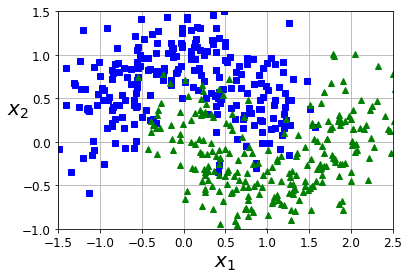

In [7]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

### 3.1 Bagging

Bagging creates bootstrap samples from the training data using sampling with replacement and builds a separate classifier for each of them. To classify a new example, the decisions of the individual classifiers are combined using majority vote. 

The following code trains a Bagging ensemble of 500 decision trees; each tree is trained on 100 examples randomly sampled from the training data.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score

print("Bagging ensemble of decision trees - accuracy on test set:")
print(accuracy_score(y_test, y_pred))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_s

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  random_state=random_state)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release not

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  random_state=random_state)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release not

Bagging ensemble of decision trees - accuracy on test set:
0.904


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  random_state=random_state)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release not

### Comparing a single decision tree with a bagging ensemble of decision trees

Let's build a single decision tree for the <b> moons </b> dataset and compare the accuracy with the Bagging ensemble of decision trees from the previous step.

In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Accuracy on test set:")
print(accuracy_score(y_test, y_pred_tree))

Accuracy on test set:
0.856


/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


Now let's plot the decision boundaries:

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Saving figure Decision_tree_without_and_with_bagging_plot


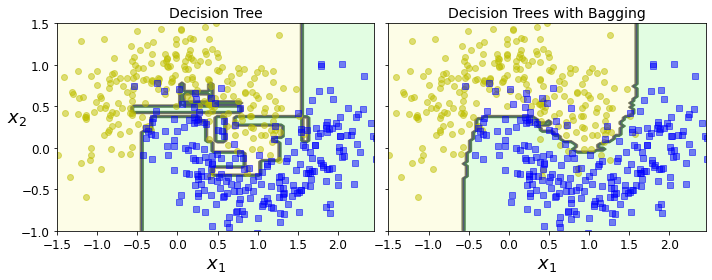

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("Decision_tree_without_and_with_bagging_plot")
plt.show()

We can see that Bagging forms a smoother (less irregular) decision boundary than the single decision tree, and hence is more more likely to work well on new data. 

Our accuracy results on the test data show that Bagging is more accurate than the single decision tree.


## 3.2 Random Forests 

A Random Forest is a collection of decison trees. Each tree should be reasonably accurate but also different from the others, which is achhieved by introducing randomness in two ways: by using bootstrap sample and considering only a subset of the attributes for each split when building the decision tree. Each tree is fully grown to fit the training data; the individual trees are likely to overfit on different parts of the data and when the predictions are combined, the amount of overfitting is reduced. 

The following code creates a Random Forest classifier consisting of 500 trees:

In [11]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print("Random forest ensemble - accuracy on test set:")
print(accuracy_score(y_test, y_pred_rf))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

Random forest ensemble - accuracy on test set:
0.912


Let's plot the decision boundary:

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


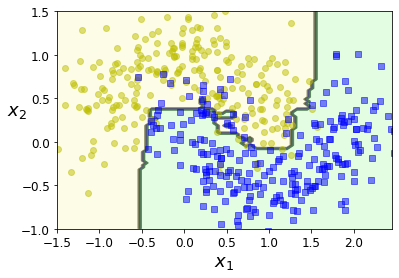

In [12]:
plot_decision_boundary(rnd_clf, X, y)

The Random Forest gives us an accuracy of 0.912, which is better than the single decision tree, and this is achieved without tuning any parameters. 

An important parameter to tune is <b> max_features</b> - the number of features to consider when looking for the best split; the default is max_features=sqrt(n_features), see:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

As we increase the number of features, the decision trees part of the ensemble become more accurate but also more similar to each other, which increases the overfitting and in turn reduces the accuracy of the ensemble. 

### Tasks:
1. Experiment with different number of trees and observe the changes in accuracy. For example, try 5, 10, 50, 100, etc. You can even plot a graph showing accuracy vs number of trees. When does the accuracy flatens and stops improving?

2. What are the disdavantages of Random Forest compared to a single decision tree?

## 3.3 Boosting

In boosting the models are trained sequentially, with the new models trying to classify correctly the examples that were difficult for the previous ones. There are many boosting methods; the most popular are AdaBoost and Gradient Boosting.

AdaBoost uses the idea of weighted training set - the higher the weight of an example, the more difficult it was for the previous classifiers. It trains a classifier, evaluates its performance on the training data and then increases the weights of the misclassified training examples. Then it trains a second classififier using the updated weights, again makes predictions on the training data, updates the weights of the training data and so on. Once all models are trained, their predictions are combined using weighed vote based on their accuracy on the training data. For more information, please se the lecture slides and textbooks.

Gradient Boosting also works by sequentially adding new  models to the ensemble, with each new model trying to predict correctly the misclassified examples by the previous models. But instead of changing the weights of the training examples, it adds a new prediction model which is trained to minimize the error of the previous models.

Both AdaBoost and GradientBoosting typically combine decision trees, in particular shallow decision trees (e.g. decision stumps which are 1-level decision trees).

The following code shows how to implement AdaBoost and Gradient Boosting in sklearn.

### AdaBoost

In [13]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)
print("AdaBoost ensemble - accuracy on test set:")
print(accuracy_score(y_test, y_pred_ada))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

AdaBoost ensemble - accuracy on test set:
0.896


/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

Plot the decision boundary:

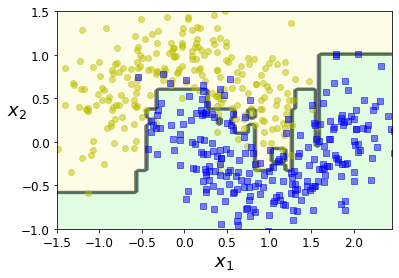

In [14]:
plot_decision_boundary(ada_clf, X, y)

### Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth=1, n_estimators=200, learning_rate=0.2, random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
print("Gradient Boosting - accuracy on test set:")
print(accuracy_score(y_test, y_pred_gb))

Gradient Boosting - accuracy on test set:
0.896


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1348: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.object)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1570: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_mask = np.ones((n_samples, ), dtype=np.bool)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.p

Plot the decision boundary:

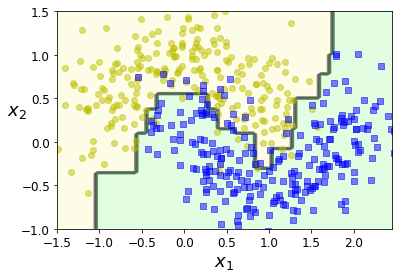

In [16]:
plot_decision_boundary(gb_clf, X, y)

## Summary

In [17]:
tree = DecisionTreeClassifier()
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True)
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5)
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2)

### Acknowledgements

This tutorial is based on:

Aurelien Geron (2019). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.

Andreas C. Mueller and Sarah Guido (2016). Introduction to Machine Learning with Python: A Guide for Data Scientists, O'Reilly.